# Setup and Imports

In [ ]:
!pip install seqeval evaluate peft --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import torch
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.scheme import IOB2
from peft import LoraConfig, get_peft_model

# Data Loading and Preprocessing

In [ ]:
# Load and preprocess the NER dataset, then split into train/val/test sets
file_path = "/kaggle/input/nerskill-id/NERSkill.Id.txt"
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence #", "Word", "Tag"], skiprows=1)
df["Sentence #"] = df["Sentence #"].ffill()

# Convert to sentences with (word, tag) pairs
sentences = df.groupby("Sentence #", group_keys=False).apply(
    lambda s: list(zip(s["Word"], s["Tag"]))).tolist()

# Split data
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3, random_state=42)
val_sentences, test_sentences = train_test_split(temp_sentences, test_size=1/3, random_state=42)

# Prepare tag mappings (ensure all tags are included)
all_tags = sorted(set(tag for sentence in sentences for _, tag in sentence))
tag2id = {tag: i for i, tag in enumerate(all_tags)}
id2tag = {i: tag for i, tag in enumerate(all_tags)}

# Tokenizer and Dataset Preparation

In [ ]:
# Initialize IndoBERT tokenizer and prepare Hugging Face datasets
model_checkpoint = "nreimers/MiniLM-L6-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Convert to Hugging Face Dataset format
def prepare_dataset(sentences):
    tokens = [[word for word, _ in sentence] for sentence in sentences]
    ner_tags = [[tag2id[tag] for _, tag in sentence] for sentence in sentences]

    return Dataset.from_dict({
        "tokens": tokens,
        "ner_tags": ner_tags
    })

train_dataset = prepare_dataset(train_sentences).map(tokenize_and_align_labels, batched=True)
val_dataset = prepare_dataset(val_sentences).map(tokenize_and_align_labels, batched=True)
test_dataset = prepare_dataset(test_sentences).map(tokenize_and_align_labels, batched=True)

# Model and LoRA Configuration

In [ ]:
# Load IndoBERT model and configure LoRA with PEFT
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Configure LoRA
lora_config = LoraConfig(
    task_type="TOKEN_CLS",
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor (corrected from lora_alpha ARCHI=16)
    lora_dropout=0.1,  # Dropout rate for LoRA
    target_modules=["query", "value"]  # Modules to apply LoRA (BERT-specific)
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters to confirm
model.print_trainable_parameters()

# Metrics and Training Setup

In [ ]:
# Define metrics, training arguments, and initialize Trainer
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (-100) and convert indices to tag strings
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Calculate entity-level metrics via seqeval
    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    # Flatten for token-level classification report
    flat_true = [tag for sent in true_labels for tag in sent]
    flat_pred = [tag for sent in true_predictions for tag in sent]
    token_report = classification_report(flat_true, flat_pred, output_dict=True)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
        "token_precision": token_report["weighted avg"]["precision"],
        "token_recall": token_report["weighted avg"]["recall"],
        "token_f1": token_report["weighted avg"]["f1-score"]
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="sbert-ner-peft",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Training and Evaluation

In [ ]:
# Train the model and evaluate on the test set
trainer.train()

# Evaluate on test set
test_results = trainer.predict(test_dataset)
metrics = test_results.metrics
print("\nTest Set Results:")
print(f"Token-level Precision: {metrics['test_token_precision']:.4f}")
print(f"Token-level Recall: {metrics['test_token_recall']:.4f}")
print(f"Token-level F1: {metrics['test_token_f1']:.4f}")
print(f"\nEntity-level Precision: {metrics['test_precision']:.4f}")
print(f"Entity-level Recall: {metrics['test_recall']:.4f}")
print(f"Entity-level F1: {metrics['test_f1']:.4f}")

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Token Precision,Token Recall,Token F1
1,No log,0.579411,0.000000,0.000000,0.000000,0.854706,0.730523,0.854706,0.787751
2,No log,0.469589,0.386963,0.174958,0.240967,0.870331,0.809227,0.870331,0.823617
3,No log,0.449917,0.362040,0.224080,0.276824,0.873843,0.826315,0.873843,0.832089


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarnin

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344


Test Set Results:
Token-level Precision: 0.8158
Token-level Recall: 0.8740
Token-level F1: 0.8304

Entity-level Precision: 0.3460
Entity-level Recall: 0.2041
Entity-level F1: 0.2568


# Token-Level Evaluation and Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Detailed Token-Level Classification Report (All Tags):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    B-HSkill       0.28      0.01      0.02       995
    B-SSkill       0.00      0.00      0.00       458
      B-Tech       0.48      0.68      0.56       943
    I-HSkill       0.61      0.04      0.07       642
    I-SSkill       0.00      0.00      0.00       145
      I-Tech       0.00      0.00      0.00       267
           O       0.90      0.99      0.94     20294

    accuracy                           0.87     23744
   macro avg       0.32      0.25      0.23     23744
weighted avg       0.82      0.87      0.83     23744



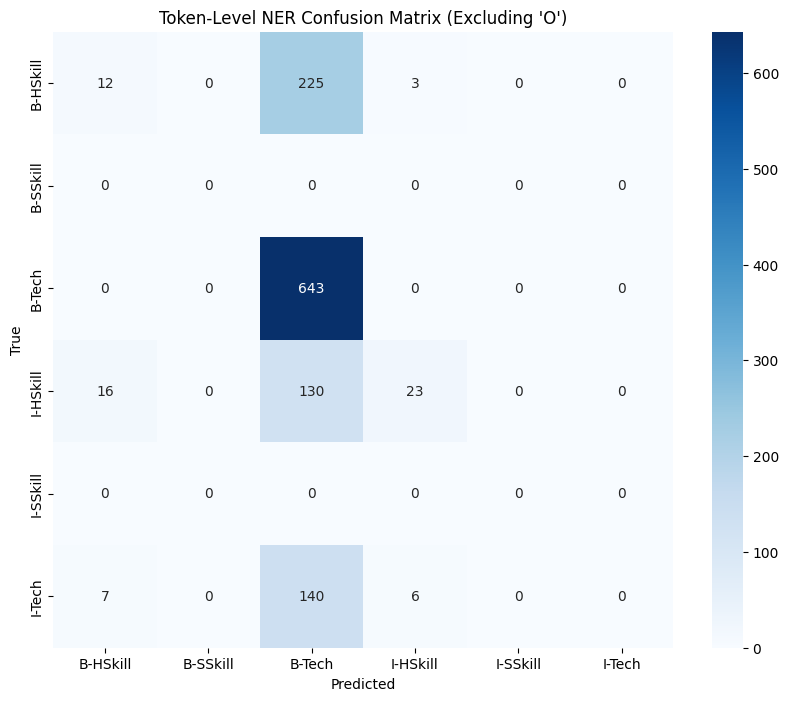

In [ ]:
# Generate detailed evaluation metrics and visualize confusion matrix
predictions = np.argmax(test_results.predictions, axis=2)
true_labels_matrix = test_results.label_ids

# Filter out ignored labels (-100) and convert indices to tags
true_predictions = [
    [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels_matrix)
]
true_labels = [
    [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels_matrix)
]

# Flatten token-level predictions and labels
flat_true = [tag for sent in true_labels for tag in sent]
flat_pred = [tag for sent in true_predictions for tag in sent]

# Exclude tokens whose gold label is 'O'
filtered_indices = [i for i, tag in enumerate(flat_true) if tag != "O"]
flat_true_noO = [flat_true[i] for i in filtered_indices]
flat_pred_noO = [flat_pred[i] for i in filtered_indices]
entity_labels = [tag for tag in sorted(tag2id.keys()) if tag != "O"]

# Token-level classification report (including 'O' tag)
print("\nDetailed Token-Level Classification Report (All Tags):")
print(classification_report(flat_true, flat_pred, target_names=sorted(tag2id.keys())))

# Confusion matrix
cm_token = confusion_matrix(flat_true_noO, flat_pred_noO, labels=entity_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_token, annot=True, fmt="d", cmap="Blues", xticklabels=entity_labels, yticklabels=entity_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Token-Level NER Confusion Matrix (Excluding 'O')")
plt.show()

# Entity-Level Evaluation and Visualization


Entity-Level Classification Report (seqeval):
              precision    recall  f1-score   support

      HSkill       0.14      0.01      0.01       995
      SSkill       0.00      0.00      0.00       458
        Tech       0.36      0.51      0.42       943

   micro avg       0.35      0.20      0.26      2396
   macro avg       0.17      0.17      0.15      2396
weighted avg       0.20      0.20      0.17      2396



/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


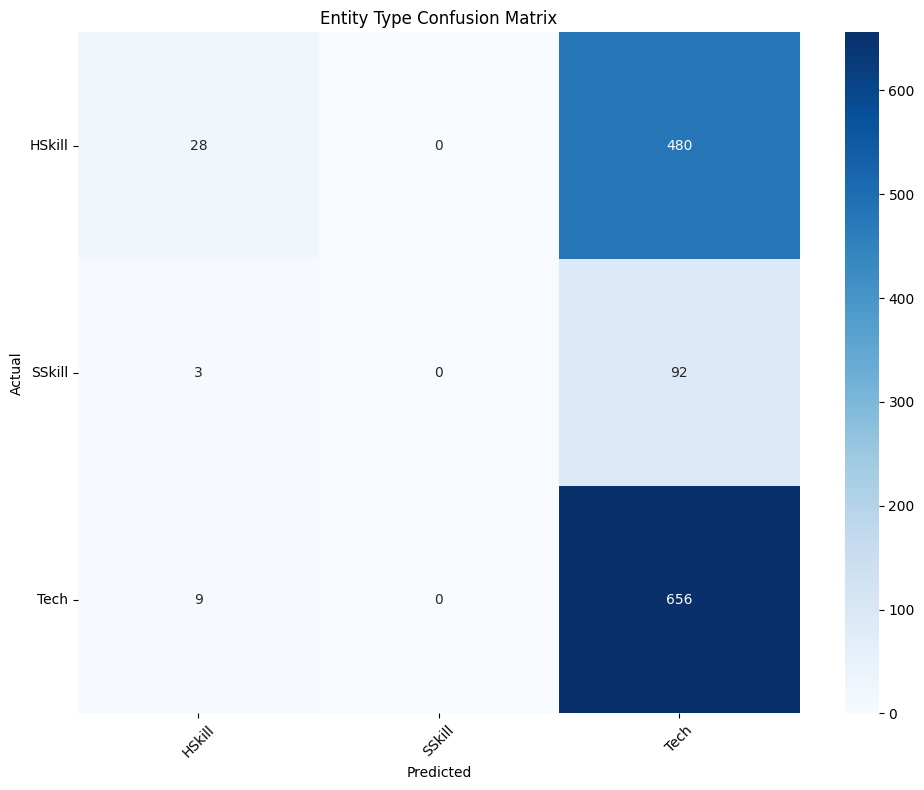

In [ ]:
# Perform entity-level evaluation and visualize confusion matrix
# Extract true predictions and labels (removing padding labels -100)
true_predictions = [
    [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(np.argmax(test_results.predictions, axis=2), test_results.label_ids)
]
true_labels = [
    [id2tag[l] for l in label if l != -100]
    for label in test_results.label_ids
]

# Generate and print the seqeval entity-level classification report
print("\nEntity-Level Classification Report (seqeval):")
print(seqeval_classification_report(true_labels, true_predictions, mode='strict', scheme=IOB2))

# Define a helper function to extract entity types from a sequence
def get_entity_types(tag_sequence):
    """
    Extracts entity types from a tag sequence.
    When a tag starts with 'B-', it registers a new entity.
    For simplicity, this function only collects the types (i.e., without their span positions).
    """
    entities = []
    for tag in tag_sequence:
        if tag.startswith('B-'):
            # Append the entity type (without the prefix "B-")
            entities.append(tag[2:])
    return entities

# Build lists for the confusion matrix
y_true = []
y_pred = []

for gold_seq, pred_seq in zip(true_labels, true_predictions):
    # Extract entity types from the current sentence
    gold_entities = get_entity_types(gold_seq)
    pred_entities = get_entity_types(pred_seq)

    # Determine the maximum number of entities between the two lists
    max_len = max(len(gold_entities), len(pred_entities))

    # Pad the shorter list with the placeholder "None"
    if len(gold_entities) < max_len:
        gold_entities = gold_entities + ["None"] * (max_len - len(gold_entities))
    if len(pred_entities) < max_len:
        pred_entities = pred_entities + ["None"] * (max_len - len(pred_entities))

    # Extend the overall lists
    y_true.extend(gold_entities)
    y_pred.extend(pred_entities)

# Remove "None" placeholder from the labels list to focus on recognized entity types
all_entity_types = sorted(set(y_true + y_pred))
if "None" in all_entity_types:
    all_entity_types.remove("None")

# Compute the confusion matrix using the list of entity types
cm = confusion_matrix(y_true, y_pred, labels=all_entity_types)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=all_entity_types,
    yticklabels=all_entity_types
)
plt.title('Entity Type Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()